In [1]:
from torch import nn
import torch
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision import transforms


training_dataset = FashionMNIST(
    root="res",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((32, 32))]
    ),
    download=True,
)
test_dataset = FashionMNIST(
    root="res",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((32, 32))]
    ),
    download=True,
)
print(training_dataset)
print(training_dataset.class_to_idx)



/home/minhyuk/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: res
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
           )
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


/home/minhyuk/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/minhyuk/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


X : torch.Size([128, 1, 32, 32])
y : torch.Size([128]) tensor([8, 7, 8, 5, 2, 8, 0, 5, 5, 7, 1, 0, 7, 6, 8, 9, 2, 6, 3, 0, 1, 1, 3, 7,
        8, 8, 7, 0, 1, 4, 3, 4, 5, 1, 4, 1, 4, 0, 4, 6, 1, 8, 4, 0, 0, 4, 7, 3,
        2, 2, 7, 9, 6, 9, 4, 1, 0, 5, 1, 6, 8, 6, 1, 7, 5, 0, 8, 7, 5, 7, 1, 5,
        7, 6, 0, 9, 9, 4, 6, 9, 6, 5, 6, 2, 4, 8, 0, 5, 9, 6, 2, 4, 3, 1, 0, 4,
        6, 5, 1, 7, 3, 2, 1, 4, 4, 1, 2, 7, 5, 6, 0, 1, 2, 8, 3, 9, 9, 1, 1, 4,
        4, 2, 2, 7, 3, 6, 7, 2])


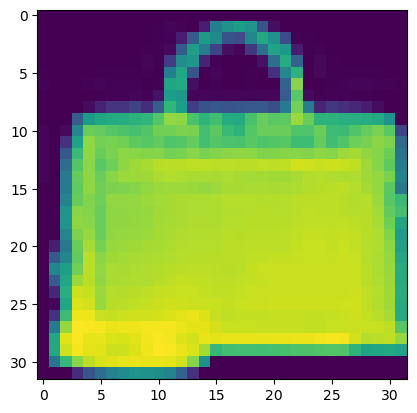

In [2]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


training_data_loader = DataLoader(training_dataset, 128, True)
for X, y in training_data_loader:
    print('X :', X.shape)
    print('y :', y.shape, y)
    plt.imshow(X[0, 0, :, :])
    break

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_downsampling):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                (3, 3),
                stride=(2, 2),
                padding=1,
                bias=False,
            )
            if is_downsampling
            else nn.Conv2d(
                in_channels, out_channels, (3, 3), padding="same", bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, (3, 3), padding="same", bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.skip = (
            nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    (1, 1),
                    stride=(2, 2),
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
            if is_downsampling
            else nn.Sequential(nn.Identity())
        )
        self.add = nn.Sequential(nn.ReLU(inplace=True))

    def forward(self, x):
        x1 = self.base(x)
        x2 = self.skip(x)
        out = torch.add(x1, x2)
        out = self.add(out)
        return out


ResidualBlock(128, 128, False)


ResidualBlock(
  (base): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (skip): Sequential(
    (0): Identity()
  )
  (add): Sequential(
    (0): ReLU(inplace=True)
  )
)

In [4]:
class ResBlockLayer(nn.Module):
    def __init__(self, in_channels, out_channels, num_of_resblocks) -> None:
        super().__init__()
        layers = []
        for _ in range(num_of_resblocks):
            if in_channels < out_channels:
                layers.append(ResidualBlock(in_channels, out_channels, True))
            else:
                layers.append(ResidualBlock(in_channels, out_channels, False))
            in_channels = out_channels
        self.base = nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        return out


ResBlockLayer(64, 128, 4)


ResBlockLayer(
  (base): Sequential(
    (0): ResidualBlock(
      (base): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (add): Sequential(
        (0): ReLU(inplace=True)
      )
    )
    (1): ResidualBlock(
      (base): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [5]:
class ResNet34(nn.Module):
    def __init__(self, in_channels, num_list_of_resblocks, num_of_classes):
        super().__init__()
        layers = []
        out_channels = 64
        layers.append(
            nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    (7, 7),
                    stride=2,
                    padding=3,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d((3, 3), stride=2, padding=1),
            )
        )
        in_channels = out_channels
        for i, num_of_resblocks in enumerate(num_list_of_resblocks):
            if i == 0:
                layers.append(
                    ResBlockLayer(in_channels, out_channels, num_of_resblocks)
                )
            else:
                out_channels = in_channels * 2
                layers.append(
                    ResBlockLayer(in_channels, out_channels, num_of_resblocks)
                )
            in_channels = out_channels
        self.feature_extract = nn.Sequential(*layers)
        self.classify = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(out_channels, 1000, bias=False),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, num_of_classes)
        )
    
    def forward(self, x):
        x = self.feature_extract(x)
        out = self.classify(x)
        return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet34(1, [3, 4, 6, 3], 10).to(device)
model

ResNet34(
  (feature_extract): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): ResBlockLayer(
      (base): Sequential(
        (0): ResidualBlock(
          (base): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (skip): Sequential(
            (0): Identity()
          )
          (add): Sequent

In [6]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
from tqdm import tqdm

def train(data_loader, model, loss_function, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        for X, y in tqdm(data_loader, desc=f"epoch {epoch} train"):
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_function(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            total_loss = 0
            total_accuracy = 0
            for X, y in tqdm(data_loader, desc=f"epoch {epoch} evaluate"):
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = loss_function(preds, y)
                total_loss += loss.item()
                total_accuracy += (preds.argmax(-1) == y).type(torch.float).sum().item()
            print(f"epoch({epoch})")
            print(f"loss : {total_loss / len(data_loader)}")
            print(f"accuracy : {total_accuracy / (len(data_loader) * data_loader.batch_size)}")

train(training_data_loader, model, loss_function, optimizer, 10, device)
        

epoch 0 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]


epoch(0)
loss : 0.27485918169463874
accuracy : 0.8920575692963753


epoch 1 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]


epoch(1)
loss : 0.19274033151709957
accuracy : 0.9294209754797441


epoch 2 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.39it/s]


epoch(2)
loss : 0.1753437400722046
accuracy : 0.9357509328358209


epoch 3 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]


epoch(3)
loss : 0.18992465645519654
accuracy : 0.9248900586353944


epoch 4 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]


epoch(4)
loss : 0.12939101667292335
accuracy : 0.9506763059701493


epoch 5 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]


epoch(5)
loss : 0.11618442759553252
accuracy : 0.9559568230277186


epoch 6 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]


epoch(6)
loss : 0.10451728583319482
accuracy : 0.9636360607675906


epoch 7 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]


epoch(7)
loss : 0.09024374990829273
accuracy : 0.9662679904051172


epoch 8 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]


epoch(8)
loss : 0.08759973451161562
accuracy : 0.966967617270789


epoch 9 evaluate: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]

epoch(9)
loss : 0.08185616606620075
accuracy : 0.9680003997867804
